In [2]:
import os
from pathlib import Path
from warnings import filterwarnings

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

filterwarnings('ignore')
print(tf.__version__)

2.9.1


In [12]:
direc = Path(r'C:/Users/hites/Downloads/Mammals_classification/mammals')
filepaths = list(direc.glob(r'**/*.jpg'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))


filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index=True, left_index=True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,C:\Users\hites\Downloads\Mammals_classificatio...,cat
1,C:\Users\hites\Downloads\Mammals_classificatio...,wolf
2,C:\Users\hites\Downloads\Mammals_classificatio...,wolf
3,C:\Users\hites\Downloads\Mammals_classificatio...,tiger
4,C:\Users\hites\Downloads\Mammals_classificatio...,bear


In [14]:
# There seems to be some bad files in the dataset let's find it
import PIL
from PIL import UnidentifiedImageError

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

for img_p in img_df.FilePaths:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_df.loc[img_df['FilePaths'] == img_p].index)
            img_df = img_df.drop(img_df.loc[img_df['FilePaths'] == img_p].index).reset_index()
            print(img_p)

Int64Index([20], dtype='int64')


ValueError: cannot insert level_0, already exists

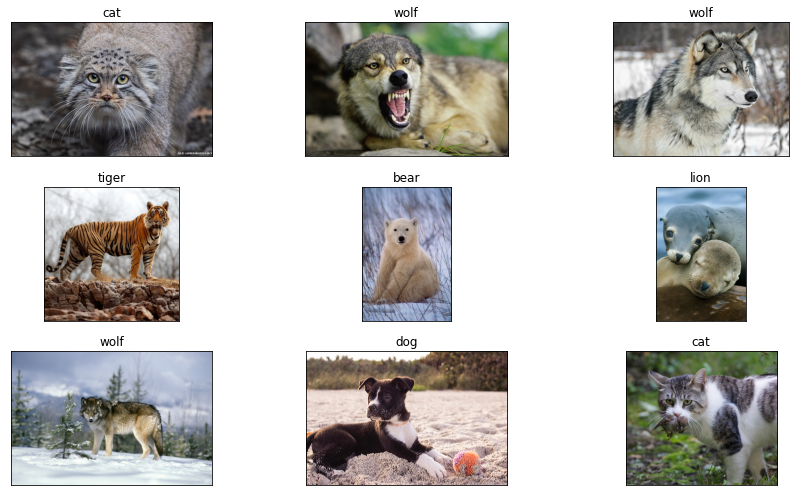

In [15]:
# Let's look at some of the images
import matplotlib.pyplot as plt
import seaborn as sns

f, a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

In [16]:
print(f" Number of Rows: {img_df.shape[0]} \n Number of Columns: {img_df.shape[1]} ")

 Number of Rows: 802 
 Number of Columns: 4 


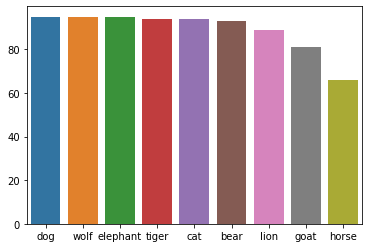

In [17]:
vals = dict(img_df['Labels'].value_counts())
sns.barplot(x=list(vals.keys()), y=list(vals.values()))
plt.show()

In [18]:
img_df

,level_0,index,FilePaths,Labels
0,0,0,C:\Users\hites\Downloads\Mammals_classificatio...,cat
1,1,1,C:\Users\hites\Downloads\Mammals_classificatio...,wolf
2,2,2,C:\Users\hites\Downloads\Mammals_classificatio...,wolf
3,3,3,C:\Users\hites\Downloads\Mammals_classificatio...,tiger
4,4,4,C:\Users\hites\Downloads\Mammals_classificatio...,bear
...,...,...,...,...
797,798,799,C:\Users\hites\Downloads\Mammals_classificatio...,cat
798,799,800,C:\Users\hites\Downloads\Mammals_classificatio...,elephant
799,800,801,C:\Users\hites\Downloads\Mammals_classificatio...,goat
800,801,802,C:\Users\hites\Downloads\Mammals_classificatio...,bear


In [19]:
X_train, X_test = train_test_split(img_df, test_size=.20)

print(f'Shape of Training Data : ',X_train.shape)
print(f'Shape of Testing Data : ',X_test.shape)

Shape of Training Data :  (641, 4)
Shape of Testing Data :  (161, 4)


In [20]:
X_train.Labels

683    tiger
141     lion
346      cat
255     lion
442    horse
       ...  
102     wolf
383    tiger
758     lion
149      cat
68     tiger
Name: Labels, Length: 641, dtype: object

In [21]:
img_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

img_size = (224, 224)

X_train = img_datagen.flow_from_dataframe(dataframe=X_train, x_col='FilePaths', y_col='Labels',
                                          target_size=img_size, color_mode='rgb', class_mode='categorical', batch_size=32)
X_test = img_datagen.flow_from_dataframe(dataframe=X_test, x_col='FilePaths', y_col='Labels',
                                         target_size=img_size, color_mode='rgb', class_mode='categorical', batch_size=32)

Found 641 validated image filenames belonging to 9 classes.
Found 161 validated image filenames belonging to 9 classes.


In [22]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [23]:
model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(rate=0.5)(model)
model = Dense(9, activation='softmax')(model)
model = Model(inputs=effnet.input, outputs = model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
print("Model compiled!")

Model compiled!


In [25]:
earlystopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

checkpointer = ModelCheckpoint(
    filepath="./mammal.h5",
    verbose=1,
    save_best_only=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", mode="min", verbose=1, patience=10, min_delta=0.0001, factor=0.2
)

In [26]:
history = model.fit(X_train,
                    validation_data=X_test, 
                    epochs=20, batch_size=32,
                    callbacks=[earlystopping, checkpointer, reduce_lr])

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000021D06BF0180>

In [27]:
# Load the best model saved
model = tf.keras.models.load_model("./mammal.h5")
loss, acc = model.evaluate(X_test)
print(f"Test Accuracy: {acc}")
print(f"Test Loss: {loss}")

OSError: No file or directory found at ./mammal.h5

NameError: name 'history' is not defined

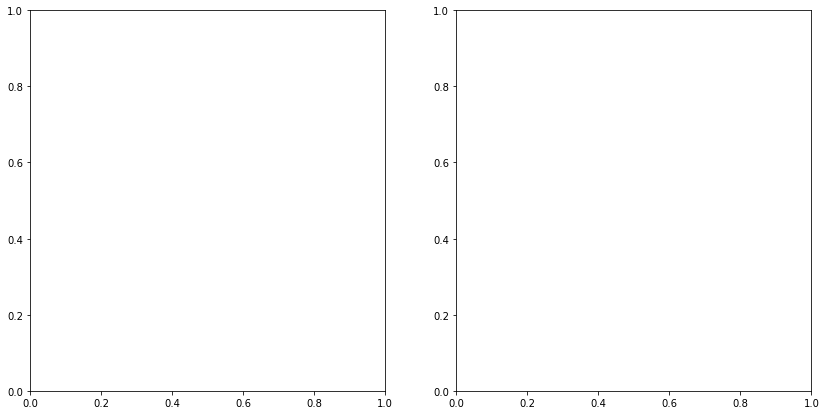

In [28]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [29]:
!wget https://cdn.britannica.com/07/5207-050-5BC9F251/Gray-wolf.jpg

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [30]:
def perdict(img):
    class_index = list(X_test.class_indices.keys())
    test_img = cv2.imread(img)
    test_img = cv2.resize(test_img, (224, 224))
    test_img = test_img.reshape((1, 224, 224, 3))
    pred = model.predict(test_img)
    return class_index[np.argmax(pred)], max(pred.ravel())

In [31]:
pred, confidence = perdict("Gray-wolf.jpg")
plt.imshow(plt.imread("Gray-wolf.jpg"))
plt.title(f"{pred} : {round(confidence, 2)*100}%")
plt.show()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [32]:
pred, confidence = perdict("220px-Elephant_Diversity.jpg")
plt.imshow(plt.imread("220px-Elephant_Diversity.jpg"))
plt.title(f"{pred} : {round(confidence, 2)*100}%")
plt.show()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
